# Methushelah's genes

Here, we will create a genetic algorthm to find great Methushelahs in Conway's Game of Life

First, we will decide the representation of the chromosomes.
Life consists of two optional states for each cell: Alive (1) and Dead (0),
which immediately cause us to think of binary representation for the grid f cells.
One approach will be to create a matrix of fixed size with the cells in binary representation.

In [1]:
import numpy as np
import random
#density - probability of each cell to be alive
Pd = [1./3,2./3]

#-----------------------------------------------
#here we will create the objects for chromosomes
class chromosome:
    def __init__(self,size):
        self.matrix = np.random.choice([1, 0], size=size, p=Pd)
        self.fitness = 0

    
    

In [2]:
#here we will have the function to create population
class population:
    def __init__(self,pop_size,chromo_size):
        self.members = [chromosome(chromo_size) for i in range(pop_size)]
    
    

The genetic operators we will have will be the _reproduction_ operator and the _mutation_ operator.

When _reproducing,_ two individuals from the population are chosen and are cut in a random point of the matrix to create an offspring of the pattern to this index of one parent combined with the rest from the other parent.

_Mutation_ will be defined as a single binary change in the initial configuration  

In [3]:
import random

#probability of mutaion:
Pm = 0.05
#probability of reproduction:
Pr = 1

#-----------------------------------------------

class population(population):
    def reproduction(self,parent1,parent2): #maybe move the selection inside this function
        if random.random() > Pr:
            return random.choice([parent1,parent2])

        size = parent1.matrix.shape
        if parent2.matrix.shape != size:
            raise ValueError('Parents shapes do not match.')
            
        offspring = chromosome(size)
        x,y = size

        #for easy slicing
        parent1.matrix.shape = (x*y)
        parent2.matrix.shape = (x*y)

        brk_pnt = np.random.choice(range(x*y))
        offspring.matrix = np.concatenate([parent1.matrix[:brk_pnt],parent2.matrix[brk_pnt:]])
        offspring.matrix.shape = size
        #are the 2 following necessary?
        parent1.matrix.shape = size
        parent2.matrix.shape = size
        
        self.add(random.choice([parent1,parent2]))
        return offspring

class chromosome(chromosome):
    def mutation(self):
        x,y = size = self.matrix.shape
        self.matrix.shape = (x*y)
        for i in range(x*y):
            if random.random() <= Pm:
                self.matrix[i] = 1-self.matrix[i]
        self.matrix.shape = size


In order to reproduce, we first need to _select_ the lucky parents!
We will use the roulette wheel selection for this.

In [4]:
class population(population):
    def select(self):
        total_fitness = sum([c.fitness for c in self.members])
        wheel_location = random.random() * total_fitness
        i = 0
        current_sum = self.members[i].fitness
        #print("cur_sum: ",current_sum)

        while ((current_sum < wheel_location) and (i < len(self.members))):
            i += 1
            current_sum += self.members[i].fitness
        selected = self.members[i]
        self.extract(selected)
        return selected

    def extract(self,chromo):
        self.members = [c for c in self.members if c!= chromo]
    
    def add(self,chromo):
        self.members += [chromo]



#### In order to select, we need to calculate the fitness of a chromosome.
This is the tricky part.

We want to give higher scores to configurations that are Methus, or close to ones.

Being a Methu is determined by the periodicity of the pattern at the end of the running.

For that, we will have to implement Life, run the configuration for a certain number of generations, and determine whether at some point the pattern repeats itself.

I have decided to run Life with a library called Seagull, only for simulating Life easily.

To determine periodicity we simply need to find a pattern that is identical to a pattern that was already shown,

That way, due to the determinism of CA, we will always get the same configurations following the identical patterns, meaning we've found periodicity.

So, when finding such a couple, we can say we have reached the lifespan (L) of the configuration.

For fitness I have decided to combine two tests:
 - the Lifespan of a configuration (L/I)
 - the peak population it had reached (P/I)
 
#### So the _fitness_ is the sum: L/I + P/I
The higher, the better.

In [5]:
from datetime import datetime
import pandas as pd


def clean(history):
    new_history = []
    for data in history:
        data = data[~np.all(data == 0, axis=1)]
        data = np.delete(data,np.where(~data.any(axis=0))[0], axis=1)
        new_history += [data]

    return new_history

In [6]:
# Some settings to show a JS animation
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"

from datetime import datetime


import seagull as sg
from seagull.lifeforms import Custom

ltc = 20
#size of the board
Sb = (150,150)
#number of iterations
In = 4000

#-----------------------------------------------

class chromosome(chromosome):
    def cal_fitness(self):
        start_event = (datetime.now())

        x,y = Sb
        xc,yc = self.matrix.shape
        
        board = sg.Board(size=(Sb))
        board.add(Custom(self.matrix), loc=(x//2-xc//2,y//2-yc//2))
        sim = sg.Simulator(board)
        stats = sim.run(sg.rules.conway_classic, iters=In)
        history = sim.get_history().astype(int)
        history = clean(history)
        g = 0
        lifespan = 0
        found = False

        for gen in history:
            if g == 0:
                g+=1
                continue

            ite = history[g-1:g-ltc:-1] if g > ltc else history[g-1::-1]
            for prev in ite:
                comp = gen == prev
                if type(comp) != bool: #if it's bool, then sizes don't match and datas not same.
                    if comp.all():
                        lifespan = g
                        found = True
                        break
            if found:
                break
            g+=1
        self.matrix.shape = (xc*yc)
        self.I = I = sum(self.matrix)
        self.matrix.shape = (xc,yc)
        self.L = L = lifespan
#         history[L].shape = (x*y)
#         F = sum(history[L])
#         history[L].shape = (x,y)
        self.P = P = stats["peak_cell_coverage"] * x*y #that's the pop size at its highest
        
        self.fitness = L/I + P/I if (L > 0) else 0
        if L == 0 and self.fitness != 0:
            print("problem")
        end_event = (datetime.now())
        self.cal_time = end_event-start_event
        self.cal_time = self.cal_time.seconds+self.cal_time.microseconds/1000000


### Now, we can run the evolution algorithm itself!

In [7]:
import copy

even = False
pop_size = 3
chromo_size = (6,6)
pop = population(pop_size,chromo_size)
fit_rise = []
fit_max_rise = []
maxes_config = []
for c in pop.members:
    c.cal_fitness()

old_fit_avg = sum([c.fitness for c in pop.members])/len(pop.members)
old_fit_max = max([c.fitness for c in pop.members])
avg_time = sum([c.cal_time for c in pop.members])/len(pop.members)
print(avg_time)
print("old pop: ",[c.fitness for c in pop.members])
print("avg: ",old_fit_avg)
fit_rise += [old_fit_avg]
fit_max_rise += [old_fit_max]
for c in pop.members:
    if c.fitness == old_fit_max:
        maxes_config += [c]
        break
    
for p in range(100):
    print("generation: ",p+1)
    print("-------------------")
    
    new_pop = population(0,0)
    m = 0
    for c in pop.members:
        if c.fitness > m:
            m = c.fitness
            mc = c
    new_pop.add(mc)
#     mmc = copy.deepcopy(mc)
#     mmc.mutation()
#     new_pop.add(mmc)
    while len(pop.members) >= 2 :
        p1 = pop.select()
        p2 = pop.select()
        os = pop.reproduction(p1,p2)
        if os: 
            os.mutation()
            if len(new_pop.members) < pop_size:
                new_pop.add(os)
    if len(pop.members) > 0 and len(new_pop.members) < pop_size:
        for os in pop.members:
            new_pop.add(os)
    for c in new_pop.members:
        c.cal_fitness()

    fit_avg = sum([c.fitness for c in new_pop.members])/len(new_pop.members)
    fit_max = max([c.fitness for c in new_pop.members])
    print("new pop: ",[c.fitness for c in new_pop.members])
    print("avg: ",fit_avg)
    print("max: ",fit_max)
    fit_rise += [fit_avg]
    fit_max_rise += [fit_max]
    avg_time = sum([c.cal_time for c in new_pop.members])/len(new_pop.members)
    print(avg_time)
    for c in new_pop.members:
        if c.fitness == fit_max:
            maxes_config += [c]
            break
    if fit_rise[-1] == fit_rise[-2]:
        even = True
        break
    
    
    pop = new_pop


2021-12-22 21:30:52.085 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
C:\Users\mimis\Anaconda3\lib\site-packages\seagull\utils\statistics.py:23: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.log2([zero_probs, one_probs]))
C:\Users\mimis\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
2021-12-22 21:30:59.562 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:31:08.512 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


7.976195333333333
old pop:  [1.375, 2.0, 1.5]
avg:  1.625
generation:  1
-------------------


2021-12-22 21:31:16.429 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:31:23.915 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:31:31.367 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [2.0, 1.3, 4.785714285714286]
avg:  2.695238095238095
max:  4.785714285714286
7.599676666666667
generation:  2
-------------------


2021-12-22 21:31:39.018 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:31:46.576 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:31:54.034 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [4.785714285714286, 5.846153846153845, 1.3]
avg:  3.9772893772893774
max:  5.846153846153845
7.534921333333333
generation:  3
-------------------


2021-12-22 21:32:01.608 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:32:09.408 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:32:17.361 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [5.846153846153845, 144.53333333333333, 1.8181818181818183]
avg:  50.73255633255633
max:  144.53333333333333
7.7668800000000005
generation:  4
-------------------


2021-12-22 21:32:24.988 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:32:33.071 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:32:41.493 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 23.23076923076923, 4.538461538461538]
avg:  57.43418803418803
max:  144.53333333333333
8.022134
generation:  5
-------------------


2021-12-22 21:32:49.460 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:32:58.804 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:33:06.593 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 3.076923076923077, 23.23076923076923]
avg:  56.947008547008544
max:  144.53333333333333
8.32063
generation:  6
-------------------


2021-12-22 21:33:14.253 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:33:22.369 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:33:29.886 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 1.6666666666666665, 36.07142857142857]
avg:  60.757142857142846
max:  144.53333333333333
7.760276999999999
generation:  7
-------------------


2021-12-22 21:33:37.516 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:33:45.466 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:33:54.166 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 23.52941176470588, 1.7857142857142856]
avg:  56.61615312791783
max:  144.53333333333333
8.092831666666667
generation:  8
-------------------


2021-12-22 21:34:02.753 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:34:10.705 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:34:18.295 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 18.0, 1.5384615384615383]
avg:  54.690598290598295
max:  144.53333333333333
8.073905
generation:  9
-------------------


2021-12-22 21:34:26.116 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:34:34.173 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:34:42.118 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 135.0625, 17.428571428571427]
avg:  99.00813492063492
max:  144.53333333333333
7.8260683333333345
generation:  10
-------------------


2021-12-22 21:34:50.856 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:34:59.838 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:35:07.774 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 9.461538461538462, 17.428571428571427]
avg:  57.14114774114773
max:  144.53333333333333
8.529008
generation:  11
-------------------


2021-12-22 21:35:15.299 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:35:23.470 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:35:31.029 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 1.5, 5.615384615384615]
avg:  50.549572649572646
max:  144.53333333333333
7.725999666666667
generation:  12
-------------------


2021-12-22 21:35:38.749 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:35:46.700 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:35:54.196 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 3.875, 2.1333333333333333]
avg:  50.18055555555555
max:  144.53333333333333
7.712926333333333
generation:  13
-------------------


2021-12-22 21:36:01.849 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:36:10.653 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:36:20.872 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 1.5714285714285714, 23.333333333333332]
avg:  56.47936507936509
max:  144.53333333333333
8.990479666666666
generation:  14
-------------------


2021-12-22 21:36:29.407 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:36:38.095 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:36:46.621 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [144.53333333333333, 154.85714285714286, 2.0]
avg:  100.46349206349207
max:  154.85714285714286
8.430343
generation:  15
-------------------


2021-12-22 21:36:54.275 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:37:02.354 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:37:09.944 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.5625, 1.7857142857142856]
avg:  53.06845238095238
max:  154.85714285714286
7.753827
generation:  16
-------------------


2021-12-22 21:37:17.461 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:37:25.597 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:37:33.091 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 13.538461538461538, 8.5]
avg:  58.96520146520147
max:  154.85714285714286
7.765826666666666
generation:  17
-------------------


2021-12-22 21:37:40.879 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:37:48.879 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:37:56.390 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.857142857142857, 98.06666666666666]
avg:  85.26031746031747
max:  154.85714285714286
7.760616333333334
generation:  18
-------------------


2021-12-22 21:38:04.381 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:38:12.540 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:38:20.048 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 3.533333333333333, 5.199999999999999]
avg:  54.530158730158725
max:  154.85714285714286
7.790446333333333
generation:  19
-------------------


2021-12-22 21:38:27.626 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:38:35.681 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:38:43.197 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 13.538461538461538, 13.538461538461538]
avg:  60.64468864468865
max:  154.85714285714286
7.708921666666666
generation:  20
-------------------


2021-12-22 21:38:50.750 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:38:58.870 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:39:06.503 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.3571428571428568, 33.07142857142857]
avg:  63.42857142857142
max:  154.85714285714286
7.766348666666667
generation:  21
-------------------


2021-12-22 21:39:14.243 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:39:22.176 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:39:29.720 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.764705882352941, 13.538461538461538]
avg:  57.05343675931911
max:  154.85714285714286
7.713008333333334
generation:  22
-------------------


2021-12-22 21:39:37.580 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:39:45.901 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:39:53.557 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.4375, 8.785714285714285]
avg:  55.360119047619044
max:  154.85714285714286
7.940425666666667
generation:  23
-------------------


2021-12-22 21:40:01.726 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:40:09.714 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:40:17.231 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 5.4, 40.83333333333333]
avg:  67.03015873015873
max:  154.85714285714286
7.876529333333333
generation:  24
-------------------


2021-12-22 21:40:25.102 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:40:34.216 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:40:42.547 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 3.2941176470588234, 1.7142857142857142]
avg:  53.28851540616247
max:  154.85714285714286
8.454368333333333
generation:  25
-------------------


2021-12-22 21:40:50.813 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:40:59.164 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:41:07.524 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 10.1875, 21.0625]
avg:  62.035714285714285
max:  154.85714285714286
8.279351333333333
generation:  26
-------------------


2021-12-22 21:41:16.004 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:41:25.673 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:41:34.470 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 10.23529411764706, 3.875]
avg:  56.32247899159665
max:  154.85714285714286
8.93235
generation:  27
-------------------


2021-12-22 21:41:42.931 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:41:51.005 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:41:58.594 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 6.333333333333334, 110.65]
avg:  90.61349206349207
max:  154.85714285714286
8.135216999999999
generation:  28
-------------------


2021-12-22 21:42:06.766 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:42:14.809 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:42:22.372 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 15.368421052631579, 154.85714285714286]
avg:  108.36090225563912
max:  154.85714285714286
7.9240026666666665
generation:  29
-------------------


2021-12-22 21:42:30.893 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:42:39.020 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:42:46.487 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.7857142857142856, 8.88888888888889]
avg:  55.510582010582006
max:  154.85714285714286
7.860088
generation:  30
-------------------


2021-12-22 21:42:54.002 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:43:02.499 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:43:10.001 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.7857142857142856, 2.3571428571428568]
avg:  53.333333333333336
max:  154.85714285714286
7.802616
generation:  31
-------------------


2021-12-22 21:43:17.867 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:43:26.287 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:43:34.801 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 36.230769230769226, 1.9333333333333331]
avg:  64.34041514041515
max:  154.85714285714286
8.260962999999999
generation:  32
-------------------


2021-12-22 21:43:42.525 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:43:51.103 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:43:58.763 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 5.923076923076923, 1.9333333333333331]
avg:  54.237851037851044
max:  154.85714285714286
8.019736
generation:  33
-------------------


2021-12-22 21:44:07.426 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:44:17.259 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:44:26.847 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 144.83333333333334, 1.8666666666666667]
avg:  100.51904761904763
max:  154.85714285714286
9.378777
generation:  34
-------------------


2021-12-22 21:44:36.810 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:44:46.566 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:44:54.825 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 3.0, 1.7142857142857144]
avg:  53.1904761904762
max:  154.85714285714286
9.186897
generation:  35
-------------------


2021-12-22 21:45:02.330 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:45:10.294 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:45:18.430 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 5.533333333333333, 5.416666666666667]
avg:  55.26904761904762
max:  154.85714285714286
7.9708836666666665
generation:  36
-------------------


2021-12-22 21:45:27.311 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:45:35.571 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:45:43.166 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 22.8125, 5.533333333333333]
avg:  61.06765873015873
max:  154.85714285714286
8.095600333333332
generation:  37
-------------------


2021-12-22 21:45:50.625 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:45:59.413 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:46:08.048 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 1.6470588235294117, 17.176470588235293]
avg:  57.893557422969195
max:  154.85714285714286
8.291575
generation:  38
-------------------


2021-12-22 21:46:15.643 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:46:23.590 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:46:31.152 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 5.875, 5.8125]
avg:  55.514880952380956
max:  154.85714285714286
7.6991559999999994
generation:  39
-------------------


2021-12-22 21:46:38.873 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:46:46.834 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:46:54.551 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 44.875, 2.2666666666666666]
avg:  67.33293650793651
max:  154.85714285714286
7.828756333333334
generation:  40
-------------------


2021-12-22 21:47:02.489 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:47:10.536 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:47:18.541 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 154.85714285714286, 1.8125]
avg:  103.84226190476191
max:  154.85714285714286
7.894047333333333
generation:  41
-------------------


2021-12-22 21:47:26.267 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:47:34.333 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:47:42.318 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 1.6428571428571428, 8.5]
avg:  55.0
max:  154.85714285714286
7.972366000000001
generation:  42
-------------------


2021-12-22 21:47:50.420 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:47:58.399 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:48:06.249 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.1818181818181817, 7.846153846153847]
avg:  54.96170496170496
max:  154.85714285714286
7.906045333333334
generation:  43
-------------------


2021-12-22 21:48:13.957 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:48:22.049 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:48:29.665 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 5.5, 1.6666666666666665]
avg:  54.007936507936506
max:  154.85714285714286
7.778338333333333
generation:  44
-------------------


2021-12-22 21:48:37.570 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:48:45.591 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:48:53.392 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 3.833333333333333, 3.090909090909091]
avg:  53.92712842712843
max:  154.85714285714286
7.924532333333334
generation:  45
-------------------


2021-12-22 21:49:01.533 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:49:09.773 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:49:17.358 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 1.923076923076923, 26.36363636363636]
avg:  61.04795204795206
max:  154.85714285714286
7.946774333333333
generation:  46
-------------------


2021-12-22 21:49:25.098 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:49:33.072 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:49:40.684 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 1.923076923076923, 25.333333333333332]
avg:  60.70451770451771
max:  154.85714285714286
7.757633333333334
generation:  47
-------------------


2021-12-22 21:49:48.424 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:49:56.381 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:50:03.975 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.235294117647059, 1.846153846153846]
avg:  52.979530273647924
max:  154.85714285714286
7.738012
generation:  48
-------------------


2021-12-22 21:50:11.506 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:50:19.733 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:50:27.301 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.1999999999999997, 32.05555555555556]
avg:  63.03756613756614
max:  154.85714285714286
7.820394333333333
generation:  49
-------------------


2021-12-22 21:50:35.575 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:50:43.880 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:50:52.477 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 3.7333333333333334, 46.3125]
avg:  68.30099206349206
max:  154.85714285714286
8.340588333333333
generation:  50
-------------------


2021-12-22 21:51:00.582 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:51:09.595 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:51:17.838 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 46.3125, 17.058823529411764]
avg:  72.74282212885154
max:  154.85714285714286
8.401410333333333
generation:  51
-------------------


2021-12-22 21:51:25.530 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:51:33.554 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:51:41.408 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.4117647058823533, 2.25]
avg:  53.17296918767507
max:  154.85714285714286
7.865915
generation:  52
-------------------


2021-12-22 21:51:49.394 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:51:58.141 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:52:05.870 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 3.0, 28.93333333333333]
avg:  62.263492063492066
max:  154.85714285714286
8.119812666666666
generation:  53
-------------------


2021-12-22 21:52:13.650 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:52:22.109 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:52:29.963 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 20.5, 19.2]
avg:  64.85238095238095
max:  154.85714285714286
8.003204666666667
generation:  54
-------------------


2021-12-22 21:52:38.000 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:52:47.586 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:52:56.579 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.176470588235294, 2.0]
avg:  53.011204481792724
max:  154.85714285714286
8.853828333333333
generation:  55
-------------------


2021-12-22 21:53:04.927 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:53:13.440 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:53:20.984 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 3.9444444444444438, 3.1176470588235294]
avg:  53.973078120136954
max:  154.85714285714286
8.096385666666668
generation:  56
-------------------


2021-12-22 21:53:28.650 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:53:36.506 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:53:44.021 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.7058823529411766, 20.65]
avg:  59.40434173669468
max:  154.85714285714286
7.681279333333333
generation:  57
-------------------


2021-12-22 21:53:51.855 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:53:59.795 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:54:07.678 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 43.5, 1.5]
avg:  66.61904761904762
max:  154.85714285714286
7.851296666666666
generation:  58
-------------------


2021-12-22 21:54:15.275 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:54:23.308 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:54:31.063 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 1.894736842105263, 1.6666666666666665]
avg:  52.806182121971595
max:  154.85714285714286
7.834057333333334
generation:  59
-------------------


2021-12-22 21:54:38.945 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:54:47.390 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:54:54.955 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 6.15, 1.6666666666666665]
avg:  54.224603174603175
max:  154.85714285714286
7.8976190000000015
generation:  60
-------------------


2021-12-22 21:55:02.878 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:55:11.349 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:55:18.993 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.263157894736842, 23.769230769230766]
avg:  60.29651050703683
max:  154.85714285714286
7.993808666666666
generation:  61
-------------------


2021-12-22 21:55:26.955 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:55:35.151 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 21:55:43.056 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [154.85714285714286, 2.266666666666667, 2.611111111111111]
avg:  53.244973544973554
max:  154.85714285714286
7.998631999999998
generation:  62
-------------------


2021-12-22 21:55:51.009 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


KeyboardInterrupt: 

we have reached early converage,
so i will try running the pop with a higher mutation probability

another thing we can try is giving priority to the two bests in the pop - making sure they are in the next pop (maybe mutated?), and also allowing them to reproduce

In [8]:
for c in new_pop.members:
    if c.fitness == 0:
        c.cal_fitness()
    print(c.matrix)
    print(c.fitness)
    

[[1 1 0 0 1 1]
 [0 0 1 0 1 1]
 [0 1 0 0 1 1]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 1 1]]
154.85714285714286


2021-12-22 21:56:12.946 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
C:\Users\mimis\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[[1 1 0 0 1 1]
 [0 0 1 0 1 0]
 [0 1 1 0 0 1]
 [1 0 1 0 0 1]
 [0 0 0 0 1 0]
 [1 1 1 0 1 0]]
6.0


2021-12-22 21:56:21.453 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


[[1 1 0 0 1 1]
 [1 0 0 0 1 1]
 [0 1 0 0 1 1]
 [0 0 1 1 0 0]
 [0 0 0 1 1 0]
 [0 0 0 1 1 0]]
3.8125


now we have the fitness of the current population
first, let's see the best methu we had so far:

In [ ]:
        import matplotlib.pyplot as plt
        from datetime import datetime
        import matplotlib
#         matplotlib.use('Agg')

        plt.rcParams["animation.html"] = "jshtml"
# m = max([c.fitness for c in maxes_config])
# for c in new_pop:
#     if c.fitness == m:
        great = copy.deepcopy(new_pop.members[0])
        board = sg.Board(size=Sb)
        board.add(Custom(great.matrix), loc=(72,72))
        sim = sg.Simulator(board)
        stats = sim.run(sg.rules.conway_classic, iters=great.L+5)
        anim = sim.animate()
        name = "P"+str(int(great.P))+"L"+str(great.L)+"I"+str(great.I)
        print(name)
        path = r"C:\Users\mimis\Desktop\hish\animation"+name+".gif"
#         anim.save(path, writer='imagemagick', fps=30)
#         break

P=423
L=1745
I=14

In [10]:
anim

My little brother and I have decided to name this configuration "Pretty Boy" after the koala from the movie "Back to the Outback" 


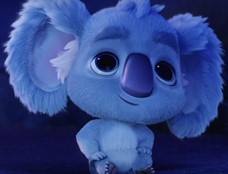

In [11]:
l_g = []
for c in maxes_config:
    l_g += [c.L]


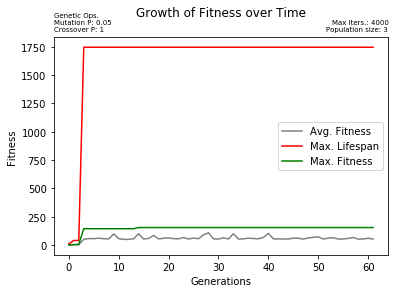

In [12]:
import matplotlib
import matplotlib.pyplot as plt

f, axs = plt.subplots(1, 1, sharex = True, sharey = True)
plt.plot(fit_rise, c="gray", label="Avg. Fitness")
plt.plot(l_g, c="red", label="Max. Lifespan")
plt.plot(fit_max_rise, c="green", label = "Max. Fitness")
plt.title("Growth of Fitness over Time\n")
plt.title("Max Iters.: "+str(In)+"\nPopulation size: "+str(len(new_pop.members)),loc="right",fontdict = {'fontsize': 7})
plt.title("Genetic Ops.\nMutation P: "+str(Pm)+"\nCrossover P: "+str(Pr),loc="left",fontdict = {'fontsize': 7})

axs.set_xlabel("Generations")
axs.set_ylabel("Fitness")
axs.legend()
plt.show()
